In [6]:
import numpy as np
import pandas as pd
from math import e
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

class pre_processing:
    def __init__(self, df):
        self.df = df

    def clean_data(self):
        df = self.df
        X = df.drop('Diabetes_binary', axis=1)
        y = df['Diabetes_binary']
        columns_to_drop = ['CholCheck','Stroke','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','Education']
        X = X.drop(columns=columns_to_drop)
        X['GenHlth'] = 6 - X['GenHlth']
        self.X = X
        self.y = y

    def train_test_split(self):
        strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=17)
        for train_idx, test_idx in strat_split.split(self.X, self.y):
            self.X_train_unscaled = self.X.iloc[train_idx]
            self.X_test_unscaled = self.X.iloc[test_idx]
            self.y_train = self.y.iloc[train_idx].values.ravel()
            self.y_test = self.y.iloc[test_idx].values.ravel()

    numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']

    def X_train_test_normalize(self, X, X_test, numerical_cols):
        X_train_scaled = X.copy()
        for col in numerical_cols:
            median = np.median(X_train_scaled[col])
            q1 = np.percentile(X_train_scaled[col], 25)
            q3 = np.percentile(X_train_scaled[col], 75)
            iqr = q3 - q1
            X_train_scaled[col] = (X_train_scaled[col] - median) / iqr
            X_test_scaled = X_test.copy()
            X_test_scaled[col] = (X_test_scaled[col] - median) / iqr
        return X_train_scaled, X_test_scaled

class Node:
    def __init__(self, x, gradient, hessian, idxs, subsample_cols=0.8, min_leaf=5,
                 min_child_weight=1, depth=10, lambda_=1, gamma=1, eps=0.1):
        # Convert to numpy array if input is pandas DataFrame
        self.x = x.values if isinstance(x, pd.DataFrame) else x
        self.gradient = gradient
        self.hessian = hessian
        self.idxs = idxs
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.eps = eps
        self.subsample_cols = subsample_cols
        self.n, self.c = len(idxs), self.x.shape[1]
        self.val = self.compute_gamma()
        self.score = -np.inf
        self.var_idx, self.split = None, None
        self.column_subsample = np.random.choice(self.c,
                                                size=max(1, int(self.c * subsample_cols)),
                                                replace=False)
        self.find_varsplit()

    def compute_gamma(self):
        return -np.sum(self.gradient[self.idxs]) / (np.sum(self.hessian[self.idxs]) + self.lambda_)

    def find_varsplit(self):
        for c in self.column_subsample:
            self.find_best_split(c)
        if self.is_leaf: return
        x = self.x[self.idxs, self.var_idx]
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.gradient, self.hessian, self.idxs[lhs], self.subsample_cols,
                        self.min_leaf, self.min_child_weight, self.depth-1, self.lambda_, self.gamma, self.eps)
        self.rhs = Node(self.x, self.gradient, self.hessian, self.idxs[rhs], self.subsample_cols,
                        self.min_leaf, self.min_child_weight, self.depth-1, self.lambda_, self.gamma, self.eps)

    def find_best_split(self, var_idx):
        x = self.x[self.idxs, var_idx]
        sort_idx = np.argsort(x)
        sorted_x, sorted_g, sorted_h = x[sort_idx], self.gradient[self.idxs][sort_idx], self.hessian[self.idxs][sort_idx]

        total_g = np.sum(sorted_g)
        total_h = np.sum(sorted_h)
        cum_g = np.cumsum(sorted_g)
        cum_h = np.cumsum(sorted_h)

        # Skip last element (no split)
        for i in range(1, self.n-1):
            # if sorted_x[i] == sorted_x[i-1]: continue  # Skip duplicate points
            g_left, h_left = cum_g[i], cum_h[i]
            g_right = total_g - g_left
            h_right = total_h - h_left

            if (i < self.min_leaf) or (self.n - i < self.min_leaf): continue
            if h_left < self.min_child_weight or h_right < self.min_child_weight: continue

            current_gain = (g_left**2 / (h_left + self.lambda_) +
                            g_right**2 / (h_right + self.lambda_) -
                            (total_g**2) / (total_h + self.lambda_)) / 2 - self.gamma
            if current_gain > self.score:
                self.var_idx = var_idx
                self.score = current_gain
                self.split = (sorted_x[i] + sorted_x[i-1]) / 2  # Midpoint for split

    @property
    def is_leaf(self):
        return self.score == -np.inf or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        child = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return child.predict_row(xi)

class XGBoostTree:
    def fit(self, x, gradient, hessian, subsample_cols=0.8, min_leaf=5, min_child_weight=1,
            depth=5, lambda_=1, gamma=1, eps=0.1):
        # Convert to numpy upfront
        x_np = x.values if isinstance(x, pd.DataFrame) else x
        self.dtree = Node(x_np, gradient, hessian, np.arange(len(x)), subsample_cols, min_leaf,
                         min_child_weight, depth, lambda_, gamma, eps)
        return self

    def predict(self, X):
        # Convert input to numpy array for prediction
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        return self.dtree.predict(X_np)

class XGBoostClassifier:
    def __init__(self):
        self.estimators = []
        self.base_pred = None

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def grad(self, preds, labels):
        return self.sigmoid(preds) - labels

    def hess(self, preds, labels):
        p = self.sigmoid(preds)
        return p * (1 - p)

    def fit(self, X, y, subsample_cols=0.8, min_child_weight=1, depth=5, min_leaf=5,
            learning_rate=0.1, boosting_rounds=10, lambda_=1, gamma=0, eps=0.1):
        self.X, self.y = X, y.values
        self.learning_rate = learning_rate

        # Initialize with log odds
        pos = y.sum()
        neg = len(y) - pos
        self.base_pred = np.full(len(y), np.log(pos/(neg + 1e-10)))  # Avoid division by zero

        for _ in range(boosting_rounds):
            grad = self.grad(self.base_pred, self.y)
            hess = self.hess(self.base_pred, self.y)
            tree = XGBoostTree().fit(X, grad, hess, subsample_cols, min_leaf, min_child_weight,
                                     depth, lambda_, gamma, eps)
            self.base_pred += self.learning_rate * tree.predict(X)
            self.estimators.append(tree)

    def predict_proba(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.estimators:
            pred += self.learning_rate * tree.predict(X)
        return self.sigmoid(pred)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

# Usage example
df = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
preprocess = pre_processing(df)
preprocess.clean_data()
preprocess.train_test_split()
X_train_scaled, X_test_scaled = preprocess.X_train_test_normalize(
    preprocess.X_train_unscaled, preprocess.X_test_unscaled, preprocess.numerical_cols)



In [7]:
clf = XGBoostClassifier()
clf.fit(X_train_scaled, pd.Series(preprocess.y_train),
        subsample_cols=1,    # use all features
        min_child_weight=5,
        depth=7,
        min_leaf=7,
        learning_rate=0.005,
        boosting_rounds=15,
        lambda_=2.5,

        gamma=2,
        eps=0.001)

# ----- PREDICTION -----
y_pred_proba = clf.predict_proba(X_test_scaled)
y_pred = clf.predict(X_test_scaled)


accuracy = accuracy_score(preprocess.y_test, y_pred)
precision = precision_score(preprocess.y_test, y_pred)
recall = recall_score(preprocess.y_test, y_pred)
f1 = f1_score(preprocess.y_test, y_pred)
report = classification_report(preprocess.y_test, y_pred)
conf_matrix = confusion_matrix(preprocess.y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy Score: 0.6929061461206591
Precision Score: 0.6326332166472189
Recall Score: 0.9202263083451202
F1 Score: 0.7497983173908033

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.47      0.60      7069
         1.0       0.63      0.92      0.75      7070

    accuracy                           0.69     14139
   macro avg       0.74      0.69      0.68     14139
weighted avg       0.74      0.69      0.68     14139


Confusion Matrix:
 [[3291 3778]
 [ 564 6506]]


In [8]:
clf = XGBoostClassifier()
clf.fit(X_train_scaled, pd.Series(preprocess.y_train),
        subsample_cols=1,    # use all features
        min_child_weight=1,
        depth=3,
        min_leaf=7,
        learning_rate=0.005,
        boosting_rounds=15,
        lambda_=0,
        gamma=0,
        eps=0.001)

# ----- PREDICTION -----
y_pred_proba = clf.predict_proba(X_test_scaled)
y_pred = clf.predict(X_test_scaled)


accuracy = accuracy_score(preprocess.y_test, y_pred)
precision = precision_score(preprocess.y_test, y_pred)
recall = recall_score(preprocess.y_test, y_pred)
f1 = f1_score(preprocess.y_test, y_pred)
report = classification_report(preprocess.y_test, y_pred)
conf_matrix = confusion_matrix(preprocess.y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy Score: 0.6929768724803734
Precision Score: 0.6360283122320806
Recall Score: 0.9024045261669024
F1 Score: 0.7461551956025964

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.48      0.61      7069
         1.0       0.64      0.90      0.75      7070

    accuracy                           0.69     14139
   macro avg       0.73      0.69      0.68     14139
weighted avg       0.73      0.69      0.68     14139


Confusion Matrix:
 [[3418 3651]
 [ 690 6380]]


In [9]:
clf = XGBoostClassifier()
clf.fit(X_train_scaled, pd.Series(preprocess.y_train),
        subsample_cols=1,    # use all features
        min_child_weight=3,
        depth=5,
        min_leaf=7,
        learning_rate=0.01,
        boosting_rounds=15,
        lambda_=1,
        gamma=1,
        eps=0.001)

# ----- PREDICTION -----
y_pred_proba = clf.predict_proba(X_test_scaled)
y_pred = clf.predict(X_test_scaled)


accuracy = accuracy_score(preprocess.y_test, y_pred)
precision = precision_score(preprocess.y_test, y_pred)
recall = recall_score(preprocess.y_test, y_pred)
f1 = f1_score(preprocess.y_test, y_pred)
report = classification_report(preprocess.y_test, y_pred)
conf_matrix = confusion_matrix(preprocess.y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy Score: 0.7042930900346559
Precision Score: 0.6487488415199258
Recall Score: 0.8910891089108911
F1 Score: 0.7508491746618199

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.52      0.64      7069
         1.0       0.65      0.89      0.75      7070

    accuracy                           0.70     14139
   macro avg       0.74      0.70      0.69     14139
weighted avg       0.74      0.70      0.69     14139


Confusion Matrix:
 [[3658 3411]
 [ 770 6300]]


In [10]:
clf = XGBoostClassifier()
clf.fit(X_train_scaled, pd.Series(preprocess.y_train),
        subsample_cols=1,    # use all features
        min_child_weight=7,
        depth=9,
        min_leaf=7,
        learning_rate=0.1,
        boosting_rounds=15,
        lambda_=5,
        gamma=3,
        eps=0.001)

# ----- PREDICTION -----
y_pred_proba = clf.predict_proba(X_test_scaled)
y_pred = clf.predict(X_test_scaled)


accuracy = accuracy_score(preprocess.y_test, y_pred)
precision = precision_score(preprocess.y_test, y_pred)
recall = recall_score(preprocess.y_test, y_pred)
f1 = f1_score(preprocess.y_test, y_pred)
report = classification_report(preprocess.y_test, y_pred)
conf_matrix = confusion_matrix(preprocess.y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy Score: 0.6955937477898012
Precision Score: 0.6342197204968945
Recall Score: 0.9243281471004243
F1 Score: 0.7522735121445838

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.47      0.61      7069
         1.0       0.63      0.92      0.75      7070

    accuracy                           0.70     14139
   macro avg       0.75      0.70      0.68     14139
weighted avg       0.75      0.70      0.68     14139


Confusion Matrix:
 [[3300 3769]
 [ 535 6535]]


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


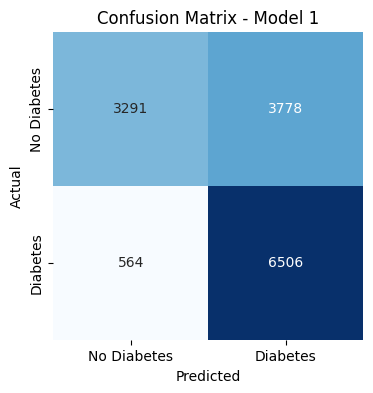

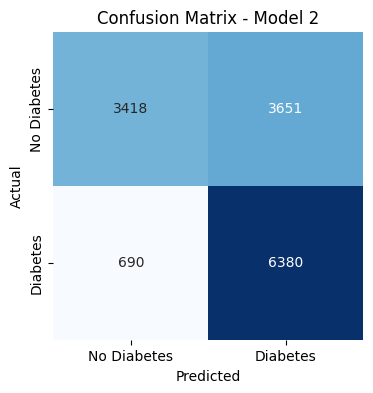

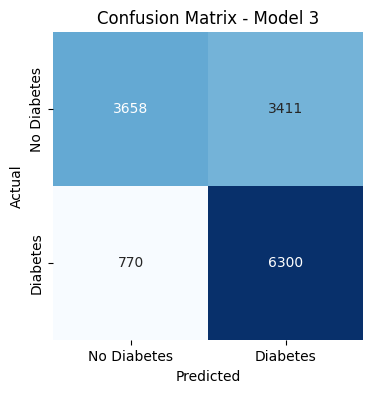

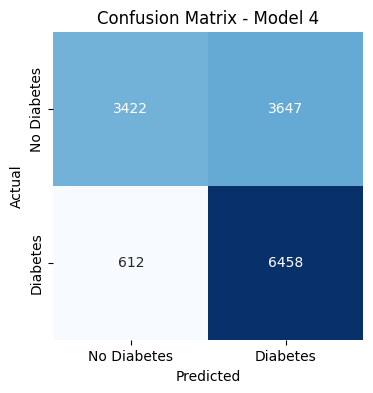

In [13]:
results = []
param_settings = [
    {"min_child_weight": 5, "depth": 7, "learning_rate": 0.005, "lambda_": 2.5, "gamma": 2},
    {"min_child_weight": 1, "depth": 3, "learning_rate": 0.005, "lambda_": 0, "gamma": 0},
    {"min_child_weight": 3, "depth": 5, "learning_rate": 0.01, "lambda_": 1, "gamma": 1},
    {"min_child_weight": 7, "depth": 9, "learning_rate": 0.1, "lambda_": 5, "gamma": 3}
]

for i, params in enumerate(param_settings, 1):
    clf = XGBoostClassifier()
    clf.fit(X_train_scaled, pd.Series(preprocess.y_train),
            subsample_cols=1,
            min_leaf=7,
            boosting_rounds=15,
            eps=0.001,
            **params)

    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)
    acc = accuracy_score(preprocess.y_test, y_pred)
    prec = precision_score(preprocess.y_test, y_pred)
    rec = recall_score(preprocess.y_test, y_pred)
    f1 = f1_score(preprocess.y_test, y_pred)
    cm = confusion_matrix(preprocess.y_test, y_pred)

    results.append({
        "model_id": f"Model {i}",
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "conf_matrix": cm,
        "params": params
    })

    # Show confusion matrix
    plot_conf_matrix(cm, f"Confusion Matrix - Model {i}")


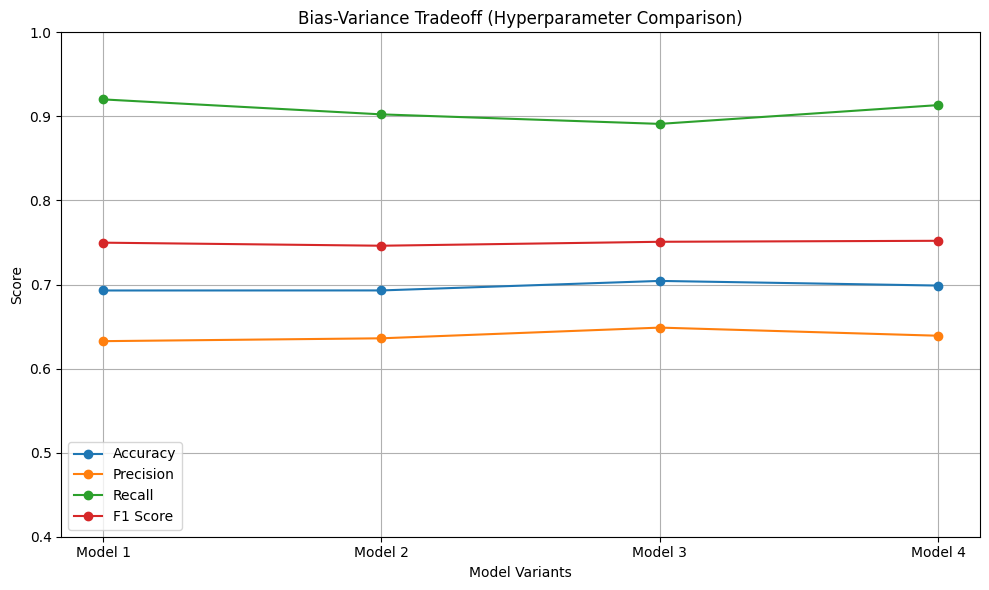

In [16]:
# Plotting the metrics to compare models
model_ids = [r["model_id"] for r in results]
accuracies = [r["accuracy"] for r in results]
precisions = [r["precision"] for r in results]
recalls = [r["recall"] for r in results]
f1_scores = [r["f1"] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(model_ids, accuracies, label='Accuracy', marker='o')
plt.plot(model_ids, precisions, label='Precision', marker='o')
plt.plot(model_ids, recalls, label='Recall', marker='o')
plt.plot(model_ids, f1_scores, label='F1 Score', marker='o')
plt.title("Bias-Variance Tradeoff (Hyperparameter Comparison)")
plt.xlabel("Model Variants")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


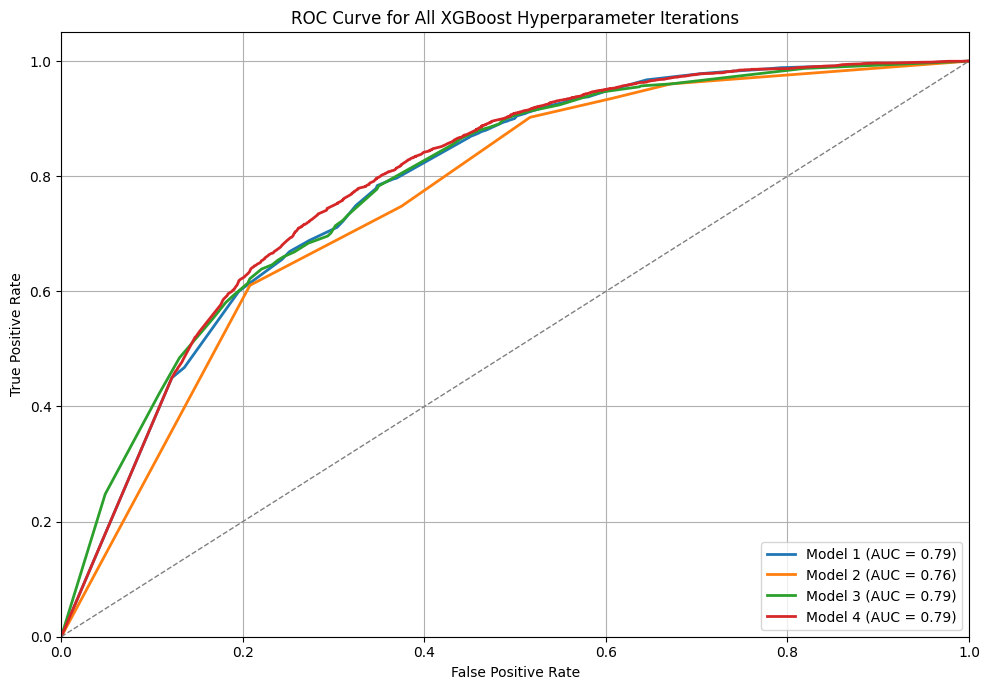

In [17]:
from sklearn.metrics import roc_curve, auc
param_settings = [
    {"min_child_weight": 3, "depth": 5, "learning_rate": 0.01, "lambda_": 1, "gamma": 1}
]
plt.figure(figsize=(10, 7))

for i, result in enumerate(results):
    clf = XGBoostClassifier()
    clf.fit(X_train_scaled, pd.Series(preprocess.y_train),
            subsample_cols=1,
            min_leaf=7,
            boosting_rounds=15,
            eps=0.001,
            **result['params'])

    # Get predicted probabilities for test set
    y_test_proba = clf.predict_proba(X_test_scaled)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(preprocess.y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"{result['model_id']} (AUC = {roc_auc:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All XGBoost Hyperparameter Iterations")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
